In [1]:
import pandas as pd
import numpy as np 
import rasterio 
import os
from glob import glob 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from loguru import logger


In [2]:
sentinel_data_df = pd.read_csv("/nas/cee-water/cjgleason/S2_Validation/GLOWS_widths_label_reaches.csv") # from Dongmei
sentinel_data_df["reach_id"] = sentinel_data_df["SWORD_reachid"]
sentinel_data_df["sentinel_width"] = sentinel_data_df["width"]
sentinel_data_df = sentinel_data_df[["reach_id", "sentinel_width"]]
sentinel_data_df = sentinel_data_df.groupby("reach_id").mean().reset_index()
sentinel_data_df.shape

(613, 2)

In [16]:
swot_data = pd.read_csv("/work/pi_smaji_umass_edu/rdaroya/planet-benchmark/swot_widths.csv")
swot_data

,reach_id,planet_fp,image_id_s2,time_s2,swot_name,swot_width,river_name
0,25240000051,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230623T094031_20230623T094034_T36WVB,2023-06-23 13:49:56,SWOT_L2_HR_RiverSP_Reach_561_012_EU_20230623T1...,3.533266e+01,Kola
1,25240000051,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230614T095559_20230614T095738_T36WVB,2023-06-14 11:30:03,SWOT_L2_HR_RiverSP_Reach_552_012_EU_20230614T1...,5.983363e+01,Kola
2,25240000051,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20240607T094041_20240607T094036_T36WVB,2024-06-07 12:33:52,SWOT_L2_HR_RiverSP_Reach_016_251_EU_20240607T0...,1.402664e+02,Kola
3,25240000051,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20240607T094041_20240607T094036_T36WVB,2024-06-07 12:33:52,SWOT_L2_HR_RiverSP_Reach_016_251_EU_20240607T0...,1.402664e+02,Kola
4,25240000051,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20240607T094041_20240607T094036_T36WVB,2024-06-07 12:33:52,SWOT_L2_HR_RiverSP_Reach_016_251_EU_20240607T0...,1.402664e+02,Kola
...,...,...,...,...,...,...,...
1140,22733000093,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230624T090601_20230624T091055_T35TMJ,2023-06-24 13:44:57,SWOT_L2_HR_RiverSP_Reach_562_014_EU_20230624T1...,-1.000000e+12,no_data
1141,22513000063,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230610T083609_20230610T083626_T36UWV,2023-06-10 10:14:26,SWOT_L2_HR_RiverSP_Reach_548_001_EU_20230610T1...,-1.000000e+12,no_data
1142,22513000063,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230620T083609_20230620T083617_T36UWV,2023-06-20 10:10:13,SWOT_L2_HR_RiverSP_Reach_558_001_EU_20230620T0...,-1.000000e+12,no_data
1143,22513000063,/nas/cee-water/cjgleason/S2_Validation/Planet_...,20230618T084601_20230618T085217_T36UWV,2023-06-18 15:16:02,SWOT_L2_HR_RiverSP_Reach_556_001_EU_20230618T0...,-1.000000e+12,no_data


In [3]:
all_planet_widths = None
for fp in tqdm(glob(os.path.join("predicted_widths", "*.csv"))):
    tmp = pd.read_csv(fp)
    if all_planet_widths is None:
        all_planet_widths = tmp
    else:
        all_planet_widths = pd.concat([all_planet_widths, tmp])
print(all_planet_widths.shape)

  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [00:00<00:00, 259.21it/s]

(12210, 11)


In [4]:
len(all_planet_widths["reach_id"].unique()), all_planet_widths.columns

(321,
 Index(['reach_id', 'planet_fp', 'cloud_cover', 'pred_raster_fp',
        'reach_len_full', 'reach_len_raster_bound', 'reach_len_pred_bound',
        'num_water_px', 'perc_water_px', 'water_area', 'sword_width'],
       dtype='object'))

In [5]:
all_planet_widths = all_planet_widths[all_planet_widths["cloud_cover"]<=0.3]
print(len(all_planet_widths["reach_id"].unique()))
all_planet_widths["diff_raster_pred_len"] = all_planet_widths["reach_len_raster_bound"]-all_planet_widths["reach_len_pred_bound"]
all_planet_widths = all_planet_widths[all_planet_widths["diff_raster_pred_len"]<=500]   # only use predictions that have <=500m difference between raster bounds and pred bounds (to filter out super wrong predictions)
print(len(all_planet_widths["reach_id"].unique()))

320
306


In [6]:
all_planet_widths["planet_fp"].iloc[0]

'/project/pi_cjgleason_umass_edu/swot_planet/unit/81260300091.0/85d31913-2e09-4386-ba10-0811318a31a9/PSScene/20240619_212933_22_2477_3B_AnalyticMS_SR_clip.tif'

In [7]:
fp = "81210100041.0--23810af8-d590-44e5-8d82-401a7170e44f--PSScene--20240922_223015_38_24fd_3B_AnalyticMS_SR_clip.tif"
planet_fp = os.path.join("/project/pi_cjgleason_umass_edu/swot_planet/unit/", "/".join(fp.split("--")))
assert os.path.exists(planet_fp)
all_planet_widths[all_planet_widths["planet_fp"]==planet_fp]


,reach_id,planet_fp,cloud_cover,pred_raster_fp,reach_len_full,reach_len_raster_bound,reach_len_pred_bound,num_water_px,perc_water_px,water_area,sword_width,diff_raster_pred_len
19,81210100041,/project/pi_cjgleason_umass_edu/swot_planet/un...,0.0,tiled_planet_predicted_merged/81210100041.0--2...,16599.78875,16674.526148,16364.440832,3470523,0.141685,31234707,1887.0,310.085316


In [8]:
sword_widths = all_planet_widths[["reach_id", "sword_width"]]
sword_widths = sword_widths.groupby("reach_id").mean().reset_index()
sword_widths = sword_widths[sword_widths["sword_width"]>0]
sword_widths.shape

(306, 2)

In [9]:
planet_widths = all_planet_widths[["reach_id", "water_area", "reach_len_pred_bound"]]
planet_widths = planet_widths.groupby("reach_id").sum().reset_index()
planet_widths["effective_width"] = planet_widths["water_area"]/planet_widths["reach_len_pred_bound"]
planet_widths.shape

(306, 4)

In [10]:
merged_res = planet_widths.merge(sentinel_data_df, how="left", on="reach_id")
merged_res = merged_res.merge(sword_widths, how="left", on="reach_id")

In [11]:
print(merged_res[merged_res["sentinel_width"]>0].shape)
print(merged_res[merged_res["sword_width"]>0].shape)

(3, 6)
(306, 6)


In [12]:
merged_res[merged_res["sentinel_width"]>0][["reach_id", "effective_width",	"sentinel_width",	"sword_width",]]

,reach_id,effective_width,sentinel_width,sword_width
216,81270501211,610.489074,610.509556,573.0
228,81280500401,182.476834,262.720204,190.0
259,81293000121,626.159260,476.620499,438.0


In [15]:
EPS=1e-6
mae = (merged_res["effective_width"]-merged_res["sword_width"]).abs().mean()
median_abs = (merged_res["effective_width"]-merged_res["sword_width"]).abs().median()
bias = -(merged_res["effective_width"]-merged_res["sword_width"]).mean()
perc_bias = (-(merged_res["effective_width"]-merged_res["sword_width"])/(merged_res["effective_width"]+EPS)).mean()

mae, median_abs, bias, perc_bias

(122.10510375561931,
 46.80916641482111,
 -84.5692038919577,
 -0.10060714725052183)

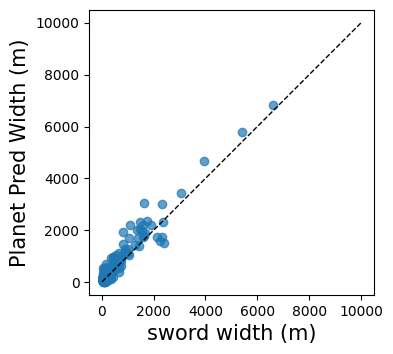

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# Configuration ‒ tweak as you like
x_columns = ['sword_width',]          # x-axis columns (left➜right)
y_column  = 'effective_width'        # shared y-axis
colors    = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
figsize   = (4*len(x_columns), 4)
alpha_pts = 0.7                      # scatter opacity
line_kw   = dict(color='black', ls='--', lw=1)  # y=x line style
# ------------------------------------

# Ensure data is in good shape (adjust if you want to keep NaNs)
data = merged_res.dropna(subset=x_columns + [y_column])

fig, axes = plt.subplots(1, len(x_columns), figsize=figsize, sharey=True)

for ax, x_col, c in zip([axes], x_columns, colors):
    # scatter points
    ax.scatter(data[x_col], data[y_column], alpha=alpha_pts, color=c)
    
    # y = x reference line
    vmin = min(data[[x_col, y_column]].min())
    vmax = max(data[[x_col, y_column]].max())
    ax.plot([vmin, 10000], [vmin, 10000], **line_kw)
    # ax.set_xlim(vmin, vmax)
    # ax.set_ylim(vmin, vmax)
    # ax.set_xlim(0, 500)
    # ax.set_ylim(0, 500)

    # labels & title
    ax.set_xlabel(x_col.replace('_', ' ')+" (m)", fontsize=15)
    # ax.set_title(f'{x_col} vs {y_column}', fontsize=20)
    ax.set_aspect('equal', adjustable='box')   # keeps squares looking square

# axes[0].set_ylabel(y_column.replace('_', ' ').title(), fontsize=20)
axes.set_ylabel("Planet Pred Width (m)", fontsize=15)
# fig.tight_layout()
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
